In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from tqdm.notebook import tqdm

# Evaluation metric

In [2]:
def get_smape(y_true, y_pred):
    '''
    https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error
    '''
    smap = np.zeros(len(y_true))
    
    num = np.abs(y_true - y_pred)
    dem = (np.abs(y_true) + np.abs(y_pred)) / 2
    
    pos_ind = (y_true!=0)|(y_pred!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    
    return 100*np.mean(smap)

# Prepare train and test sets

In [3]:
# based on https://www.kaggle.com/code/vadimkamaev/score-1-382/notebook

data_dir = '../data/'

def get_train_test():    
    # combine the original training set with the revealed data
    train = pd.concat([
        pd.read_csv(f'{data_dir}/train.csv'), 
        pd.read_csv(f'{data_dir}/revealed_test.csv')
    ]).sort_values(by=['cfips', 'first_day_of_month']).reset_index(0, drop=True)
    
    # drop the test data that has already been revealed
    test = pd.read_csv(f'{data_dir}/test.csv')
    drop_index = (test.first_day_of_month == '2022-11-01') | (test.first_day_of_month == '2022-12-01')
    test = test.loc[~drop_index, :]
    
    sub = pd.read_csv(f'{data_dir}/sample_submission.csv')
    return train, test, sub

# Combine raw data

In [4]:
def get_raw(train, test):
    d = pd.concat([train, test]).sort_values(['cfips', 'row_id']).reset_index(0, drop=True)
    d['first_day_of_month'] = pd.to_datetime(d["first_day_of_month"])
    d['county'] = d.groupby('cfips')['county'].ffill()
    d['state'] = d.groupby('cfips')['state'].ffill()
    d['county_i'] = (d['county'] + d['state']).factorize()[0]
    d['state_i'] = d['state'].factorize()[0]
    d['month_number'] = d.groupby(['cfips'])['row_id'].cumcount()
    d['y'] = d['microbusiness_density']
    d = d.drop('microbusiness_density', axis=1)
    features = ['state_i']    
    return d, features

# Feature engineering: lag and rolling

In [5]:
def add_lag(d, target='y', max_lag=8):
    features = []
    for lag in range(1, max_lag):
        d[f'{target}_lag_{lag}'] = d.groupby('cfips')[target].shift(lag)
        features.append(f'{target}_lag_{lag}')        
        # d[f'active_lag_{lag}'] = d.groupby('cfips')['active'].diff(lag)        
        # feats.append(f'active_lag_{lag}')        
    return d, features

def add_rolling(d, target='y', lags=[1]):
    
    def get_rolling(s, window):
        return s.rolling(window, min_periods=1).sum()
        
    features = []
    for lag in lags:
        for window in [2, 4, 6, 8, 10]:
            group = d.groupby('cfips')[f'{target}_lag_{lag}']
            d[f'{target}_roll_{window}_{lag}'] = group.transform(get_rolling, window=window)
            features.append(f'{target}_roll_{window}_{lag}')
    return d, features

# Feature engineering: internal and external census

In [6]:
def add_internal_census(d, features):
    census = pd.read_csv(f'{data_dir}/census_starter.csv')
    census_cols = list(census.columns)
    census_cols.remove('cfips')
    d = d.merge(census, on='cfips', how='left')
    features += census_cols
    return d, features

def add_external_census(d, features):
    '''
    data: https://www2.census.gov/programs-surveys/popest/datasets/2020-2021/counties/totals/co-est2021-alldata.csv
    schema: https://www2.census.gov/programs-surveys/popest/technical-documentation/file-layouts/2020-2021/CO-EST2021-ALLDATA.pdf
    '''
    census = pd.read_csv(f'{data_dir}/co-est2021-alldata.csv', encoding='latin-1')
    census['cfips'] = census.STATE*1000 + census.COUNTY
    features += [
        'SUMLEV', 'REGION', 'DIVISION', 'ESTIMATESBASE2020',
        'POPESTIMATE2020', 'POPESTIMATE2021',
        'NPOPCHG2020', 'NPOPCHG2021',
        'BIRTHS2020', 'BIRTHS2021',
        'DEATHS2020', 'DEATHS2021',
        'NATURALCHG2020', 'NATURALCHG2021',
        'INTERNATIONALMIG2020', 'INTERNATIONALMIG2021',
        'DOMESTICMIG2020', 'DOMESTICMIG2021',
        'NETMIG2020', 'NETMIG2021',
        'RESIDUAL2020', 'RESIDUAL2021',
        'GQESTIMATESBASE2020', 'GQESTIMATES2020', 'GQESTIMATES2021',
        'RBIRTH2021', 'RDEATH2021', 'RNATURALCHG2021', 'RINTERNATIONALMIG2021', 'RDOMESTICMIG2021', 'RNETMIG2021'
    ]
    d = d.merge(census, on='cfips', how='left')
    return d, features

# Feature engineering: coordinates

In [7]:
def add_coords(d, features):
    '''
    https://www.kaggle.com/datasets/alejopaullier/usa-counties-coordinates
    '''
    coords = pd.read_csv(f'{data_dir}/cfips_location.csv').drop('name', axis=1) 
    d = d.merge(coords, on='cfips')
    features += ['lng', 'lat']
    return d, features

# Feature engineering: all

In [8]:
def add_all_features(d):
    features = []
    d, f1 = add_lag(d, target='y')
    d, f2 = add_rolling(d, target='y')
    features += f1 + f2
    return d, features

# Model

In [9]:
def get_model():
    from sklearn.ensemble import VotingRegressor
    import lightgbm as lgb
    import xgboost as xgb
    import catboost as cat
    from sklearn.pipeline import Pipeline
    from sklearn.neighbors import KNeighborsRegressor
    from sklearn.impute import KNNImputer    

    # we should decrease the num_iterations of catboost
    cat_model = cat.CatBoostRegressor(
        iterations=800,
        loss_function="MAPE",
        verbose=0,
        grow_policy='SymmetricTree',
        learning_rate=0.035,
        colsample_bylevel=0.8,
        max_depth=5,
        l2_leaf_reg=0.2,
        # max_leaves = 17,
        subsample=0.70,
        max_bin=4096,
    )
    return cat_model

# Training

In [10]:
def iterative_train(d, month_first=36, month_last=46):    
    for train_cutoff in range(month_first, month_last+1):
        print(train_cutoff)
        model = get_model()
        train_idxs = (1 <= d.month_number) & (d.month_number < train_cutoff)
        valid_idxs = (d.month_number == train_cutoff)
        model.fit(d.loc[train_idxs, features], d.loc[train_idxs, 'y'])
        d.loc[valid_idxs, 'yhat'] = model.predict(d.loc[valid_idxs, features])
        d.loc[valid_idxs, 'smape'] = get_smape(d.loc[valid_idxs, 'yhat'], d.loc[valid_idxs, 'y'])
        d.loc[valid_idxs, 'y'] = d.loc[valid_idxs, 'y'].fillna(d.loc[valid_idxs, 'yhat'])
        d, _ = add_all_features(d)

    valid_idxs = (month_first <= d.month_number) & (d.month_number <= 40)
    print('SMAPE:', get_smape(d.loc[valid_idxs, 'y'], d.loc[valid_idxs, 'yhat']))
    return d

train, test, sub = get_train_test()
d, features = get_raw(train, test)    
d, features_temp = add_all_features(d)
features += features_temp
d = iterative_train(d)

36
37
38
39
40
41
42
43
44
45
46
SMAPE: 2.4553396844484485


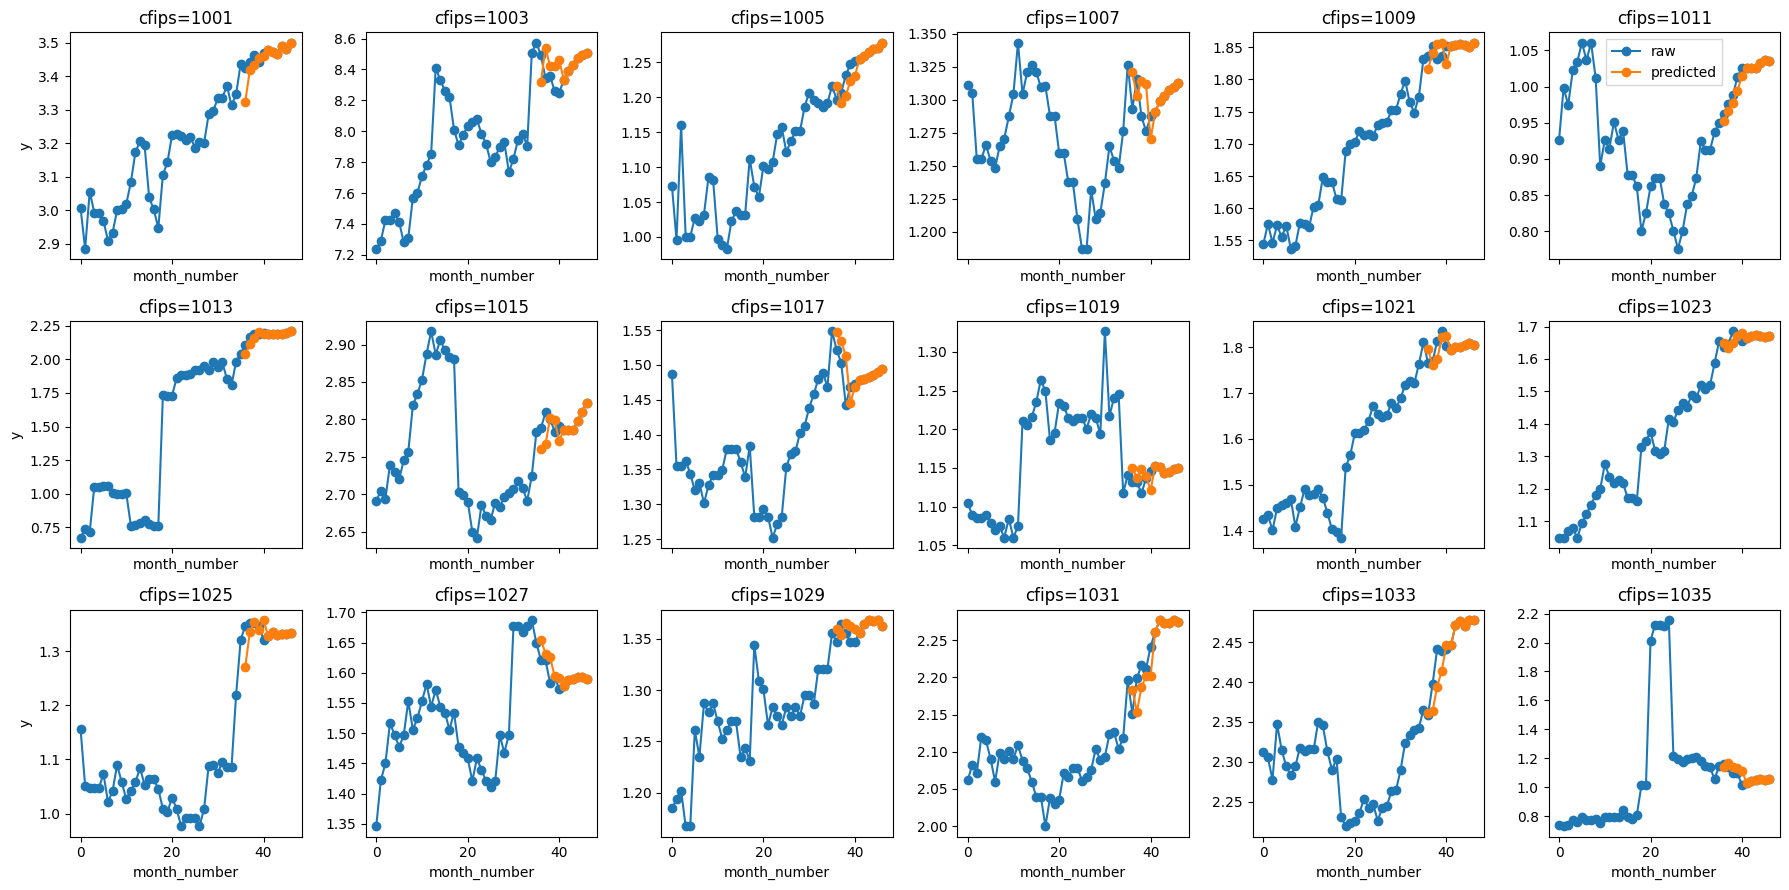

In [11]:
def plot(d, nfigs=18, ncols=6):    
    nrows = int(np.ceil(nfigs/ncols))
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*3, nrows*3), sharey=False, sharex=True)

    for i, cfips in enumerate(d.cfips.unique()):
        if i >= nfigs:
            break
        idx_row = int(i / ncols)
        idx_col = i % ncols
        if nrows == 1:
            ax = axs[idx_col]
        else:
            ax = axs[idx_row, idx_col]

        g = d.loc[d.cfips == cfips, :].reset_index(0, drop=True)        
        ax.plot(g['month_number'], g['y'], 'o-', label='raw')
        ax.plot(g['month_number'], g['yhat'], 'o-', label='predicted')
        cfips = g.cfips.unique()[0]
        ax.set_title(f'cfips={cfips}')
        ax.set_xlabel('month_number')        
        if idx_row == 0 and idx_col == ncols-1:
            ax.legend(fancybox=False)
        if idx_col == 0:
            ax.set_ylabel('y')
    
    fig.tight_layout()

plot(d)

In [12]:
def save_submission(d):    
    d = d.loc[d.month_number >= 39, ['row_id', 'y']]
    d['microbusiness_density'] = d['y']
    d = d.drop('y', axis=1)
    d.to_csv('submission.csv', index=False)
    return d

save_submission(d)

,row_id,microbusiness_density
39,1001_2022-11-01,3.442677
40,1001_2022-12-01,3.470915
41,1001_2023-01-01,3.477566
42,1001_2023-02-01,3.472878
43,1001_2023-03-01,3.468409
...,...,...
147340,56045_2023-02-01,1.799887
147341,56045_2023-03-01,1.799051
147342,56045_2023-04-01,1.781676
147343,56045_2023-05-01,1.786291
